In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

## As of 2024.04.26, I'm going to check the blowaway with the optical_pumping experiment.
The main reason we do blowaway is to check that we're getting population transfer to F=1 states, so it just makes more sense to routinely check this behavior in the optical pumping notebook.

However, I think there was an error in that code such that atoms were ejected during the readout because AOM A6 was not reduced back to the stabilizer amplitude level.

## 2024.04.24
The blow-away needs to tuned again. I realized that when I was tuning the coil values to optimize blow-away, I had forgotten to reset the coils to the readout values for shot 2 in my code, and the result was that the coils were tuned so that any atoms were heated out. 

In [4]:
fnames = get_files_by_criteria(date_filters=["2024-04-24"], # only find files from these date directories
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 2 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-24\08\000012408-GeneralVariableScan_microwave_Rabi.h5) scanned over t_blowaway
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-24\08\000012411-GeneralVariableScan_microwave_Rabi.h5) scanned over blowaway_light_off


## Optimizing blowaway
I'm using the microwave_Rabi experiment which has microwave and blowaway sections, but t_microwaves = 0 and the Valon RF source is off so this block doesn't do anything.

In [5]:
fname = fnames[0] # shows some dependence on blowaway power
fname = fnames[1] # shows high retention contrast with/without blowaway light

f = h5py.File(os.path.join(results, fname))
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
Pumping light off? True


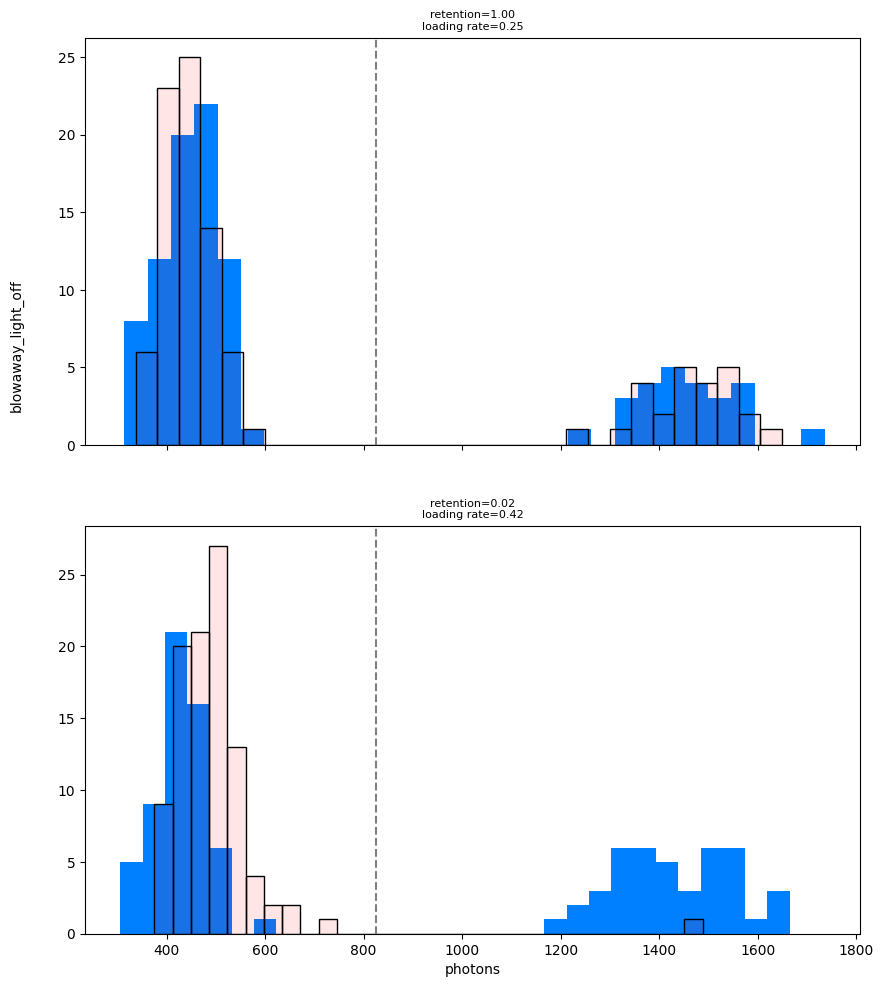

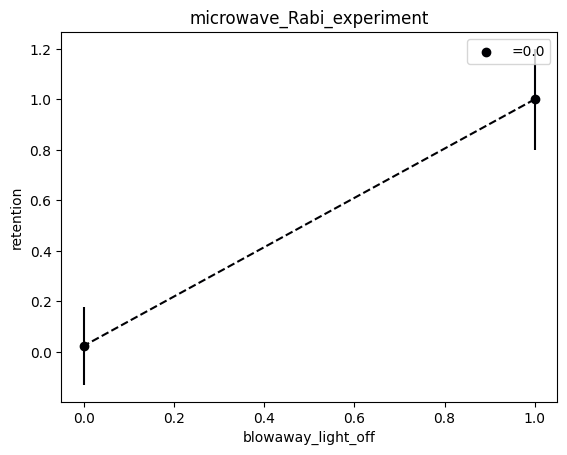

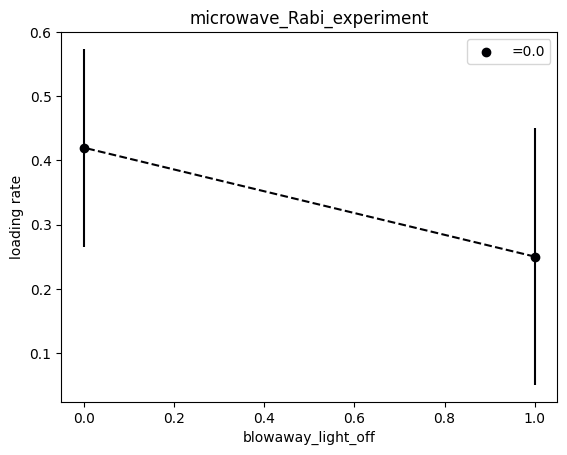

In [6]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")

    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2_name)
    fig.text(0.05,0.35, scan_variable1_name,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_function)
    ax.set_xlabel(scan_variable1_name)
    ax.set_ylabel(scan_variable2_name)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function)
        plt.show()

## 2024.04.17
The MOT and FORT parameters have been substantially tweaked so that we have good loading and retention (see readout retention and loading notebook), and now I am working toward microwave experiments so we can properly balance the B fields and get good PGC.
The first thing to improve is the blowaway experiment-- right now, I'm losing atoms even if the blowaway time is 0. The last time we did blowaway, I was setting the FORT amplitude with a value that was not proportional to the FORT_stabilizer amplitude, but now I am using p_FORT_blowaway, so I have to find the optimal value of this.

In [2]:
fnames = get_files_by_criteria(date_filters=["2024-04-17"], # only find files from these date directories
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 13 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\10\000012060-GeneralVariableScan_microwave_Rabi.h5) scanned over p_FORT_blowaway
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\10\000012061-GeneralVariableScan_microwave_Rabi.h5) scanned over t_blowaway
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\10\000012063-GeneralVariableScan_microwave_Rabi.h5) scanned over p_FORT_blowaway
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\11\000012066-GeneralVariableScan_microwave_Rabi.h5) scanned over t_blowaway
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\11\000012067-GeneralVariableScan_microwave_Rabi.h5) scanned over t_blowaway
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\11\000012070-GeneralVariableScan_microwave_Rabi.h5) scanned over p_FORT_blowaway
file 6 (C:\Networking Experiment\artiq codes\artiq-m

## Optimizing blowaway
I'm using the microwave_Rabi experiment which has microwave and blowaway sections, but t_microwaves = 0 and the Valon RF source is off so this block doesn't do anything.

In [9]:
fname = fnames[4] # retention plateaus at 0.2 beyond 30 us. It's possible the FORT power can be slightly lower. I could also increase the blowaway light power by introducing a factor for the MOT6 power
fname = fnames[5] # retention during blowaway phase (no blowaway light) is close to 1 with FORT power 0.4
fname = fnames[6] # no strong dependence on MOT6 -- oops! I put the line changing the frequency in the wrong place
fname = fnames[7] # no strong dependence on the detuning from 100 to 105 MHz for double pass
fname = fnames[10] # after running the optimizer over coil values, blowaway time, and detuning. nearly there! 3-6% of atoms aren't ejected

f = h5py.File(os.path.join(results, fname))
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")

if scan_variable2_name != '':
    try:
        scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    except:
        scan_sequence2 = np.array(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
print("Blow-away light off?", blowaway_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
Blow-away light off? False


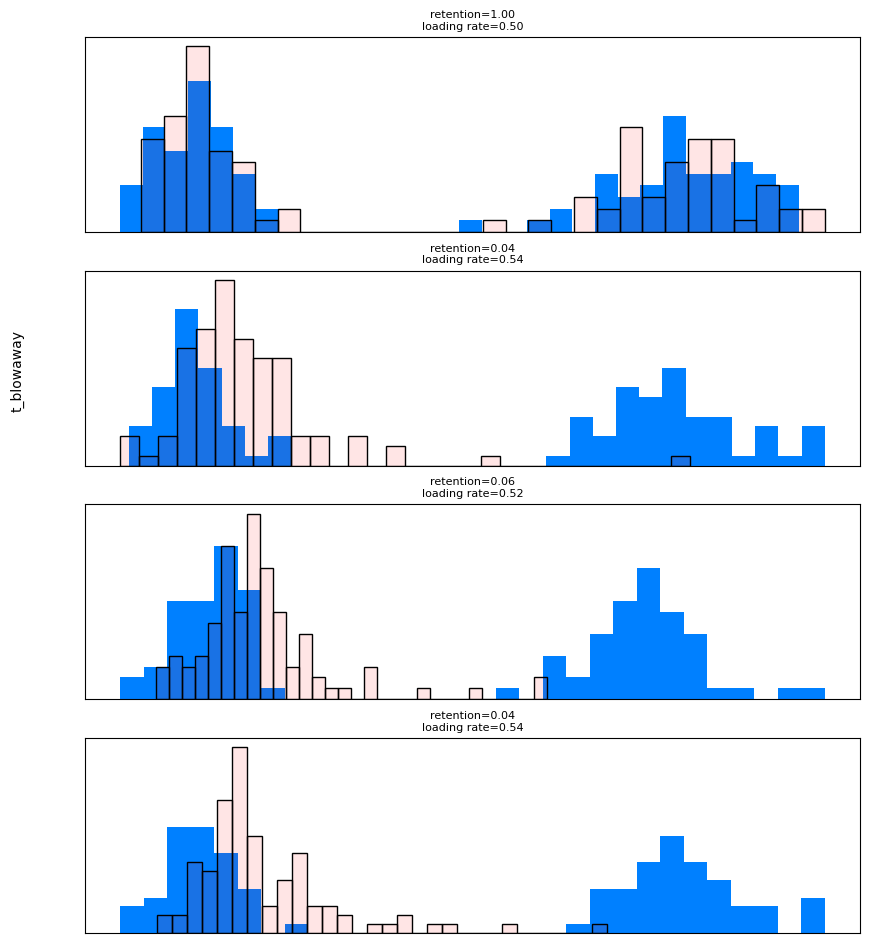

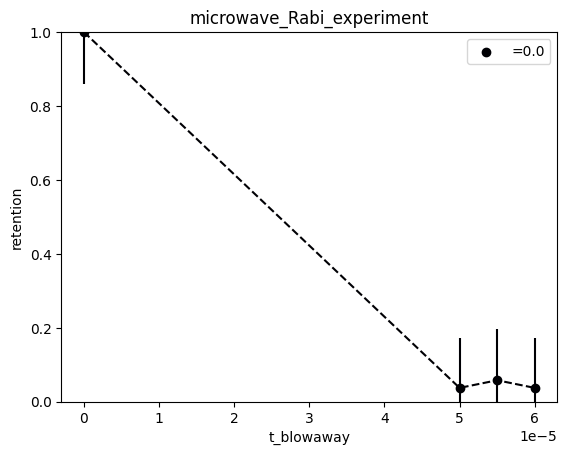

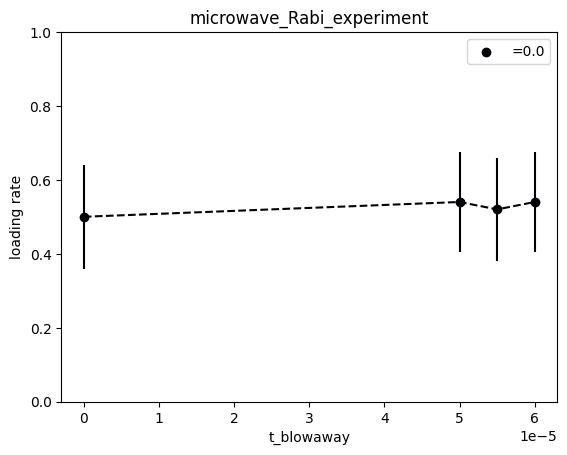

In [13]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2_name)
    fig.text(0.05,0.35, scan_variable1_name,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1_name)
    ax.set_ylabel(scan_variable2_name)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    plt.ylim((0,1))
    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_name)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
        plt.ylim((0,1))
        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_name)
        plt.show()

In [14]:
retention_array

array([1.        , 0.03703704, 0.05769231, 0.03703704])

## Optimizing retention with t_blowaway = 0
I'm using the microwave_Rabi experiment which has microwave and blowaway sections, but t_microwaves = 0 and the Valon RF source is off so this block doesn't do anything.

In [6]:
fname = fnames[0] # retention improves with higher FORT power, but I realized I had a 10 us FORT drop. now we should be good to go
fname = fnames[1] # sanity check that there is a difference between 0 blowaway and the 30*us blowaway we were using previously. a better binary check is to use blowaway_light_off
fname = fnames[2] # p_FORT_blowaway = 0.45 is sufficient to have negligible loss during the blowaway phase. no advantage beyond this.

f = h5py.File(os.path.join(results, fname))

experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
t_SPCM_first_shot = np.float64(f['archive']['t_SPCM_first_shot'])
t_SPCM_second_shot = np.float64(f['archive']['t_SPCM_second_shot'])
t_FORT_drop = np.float64(f['archive']['t_FORT_drop'])
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
single_atom_counts_per_s = np.uint(f['archive']['single_atom_counts_per_s'])

scan_variable1 = str_from_h5(f['datasets']['scan_variable1_name'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

try:
    scan_sequence1 = np.array(f['datasets']['scan_sequence1'])
except:
    scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])

scan_variable2 = str_from_h5(f['datasets']['scan_variable2_name'])
if scan_variable2 != '':
    try:
        scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    except:
        scan_sequence2 = np.array(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
p_FORT_blowaway [0.2   0.325 0.45  0.575 0.7  ]
 [0.]


In [6]:
fname = fnames[0] # retention improves with higher FORT power, but I realized I had a 10 us FORT drop. now we should be good to go
fname = fnames[1] # sanity check that there is a difference between 0 blowaway and the 30*us blowaway we were using previously. a better binary check is to use blowaway_light_off
fname = fnames[2] # p_FORT_blowaway = 0.45 is sufficient to have negligible loss during the blowaway phase. no advantage beyond this.

f = h5py.File(os.path.join(results, fname))


experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
t_SPCM_first_shot = np.float64(f['archive']['t_SPCM_first_shot'])
t_SPCM_second_shot = np.float64(f['archive']['t_SPCM_second_shot'])
t_FORT_drop = np.float64(f['archive']['t_FORT_drop'])
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
single_atom_counts_per_s = np.uint(f['archive']['single_atom_counts_per_s'])

scan_variable1 = str_from_h5(f['datasets']['scan_variable1_name'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

try:
    scan_sequence1 = np.array(f['datasets']['scan_sequence1'])
except:
    scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])

scan_variable2 = str_from_h5(f['datasets']['scan_variable2_name'])
if scan_variable2 != '':
    try:
        scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    except:
        scan_sequence2 = np.array(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

photocounts = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

locals().update({'n_measurements':n_measurements})

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
p_FORT_blowaway [0.2   0.325 0.45  0.575 0.7  ]
 [0.]


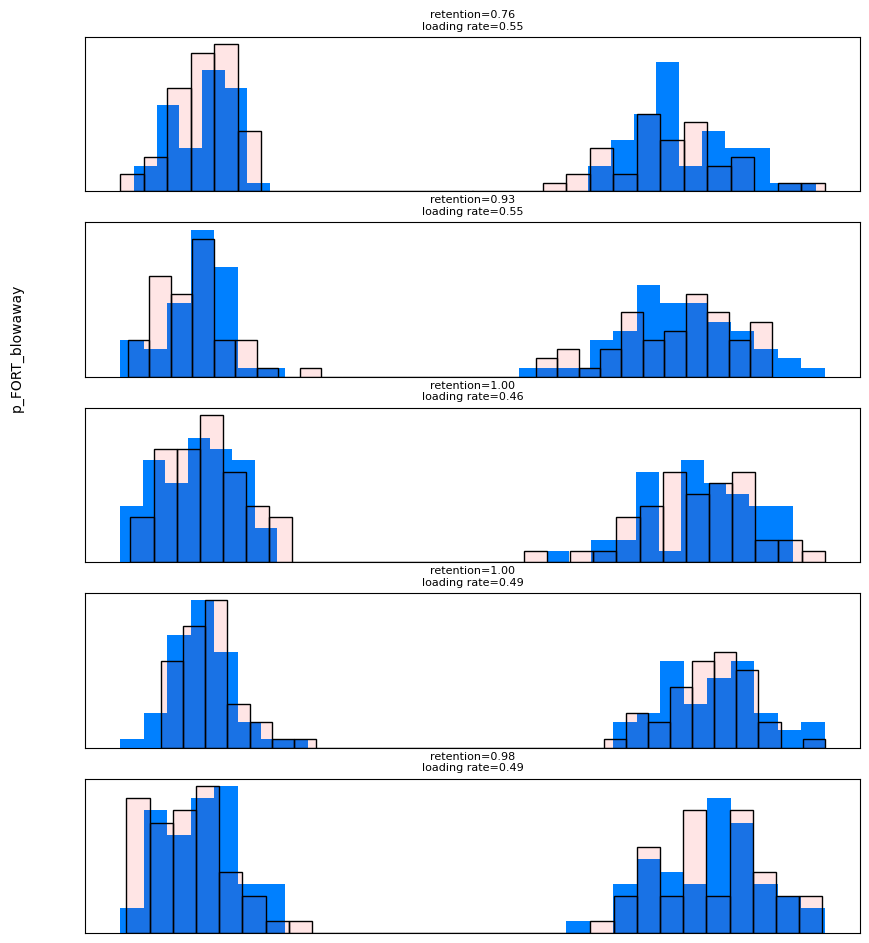

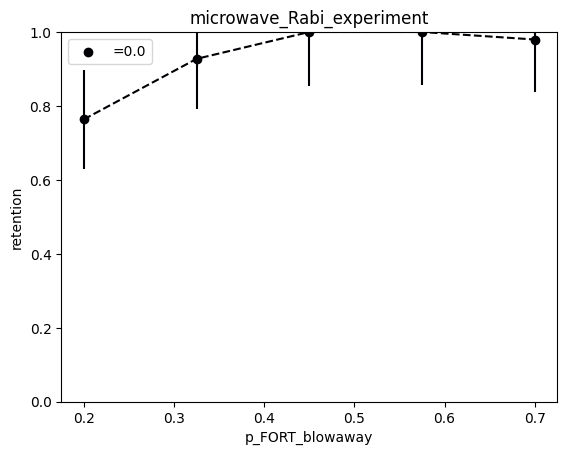

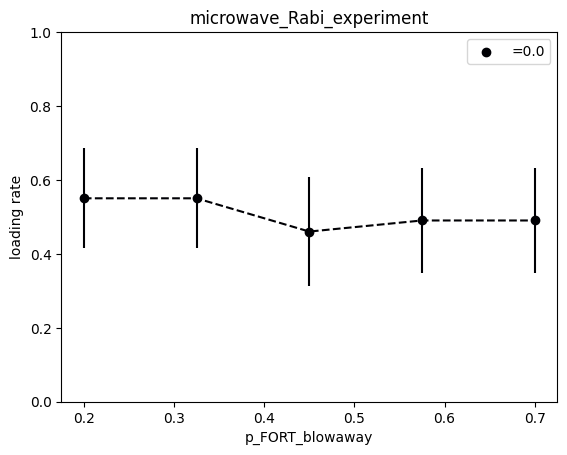

In [7]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1)
    ax.set_ylabel(scan_variable2)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    plt.ylim((0,1))
    plt.xlabel(scan_variable1)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_name)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
        plt.ylim((0,1))
        plt.xlabel(scan_variable1)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_name)
        plt.show()

In [3]:
fname = fnames[0] # retention improves with higher FORT power, but I realized I had a 10 us FORT drop. now we should be good to go
fname = fnames[1] # sanity check that there is a difference between 0 blowaway and the 30*us blowaway we were using previously. a better binary check is to use blowaway_light_off
fname = fnames[2] # p_FORT_blowaway = 0.45 is sufficient. no advantage beyond this.
fname = fnames[3] # 

f = h5py.File(os.path.join(results, fname))

experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
t_SPCM_first_shot = np.float64(f['archive']['t_SPCM_first_shot'])
t_SPCM_second_shot = np.float64(f['archive']['t_SPCM_second_shot'])
t_FORT_drop = np.float64(f['archive']['t_FORT_drop'])
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
single_atom_counts_per_s = np.uint(f['archive']['single_atom_counts_per_s'])

scan_variable1 = str_from_h5(f['datasets']['scan_variable1_name'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

try:
    scan_sequence1 = np.array(f['datasets']['scan_sequence1'])
except:
    scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])

scan_variable2 = str_from_h5(f['datasets']['scan_variable2_name'])
if scan_variable2 != '':
    try:
        scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    except:
        scan_sequence2 = np.array(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment
t_blowaway [0.e+00 5.e-06 2.e-05 3.e-04 5.e-05]
 [0.]


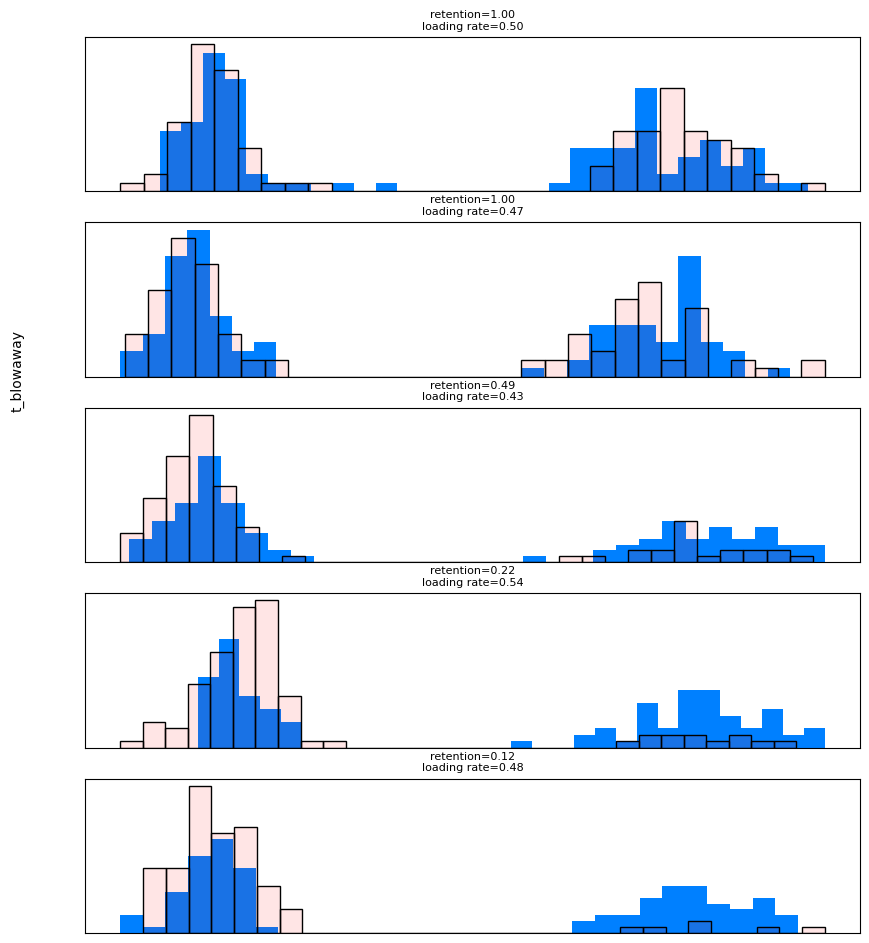

NameError: name 'scan_sequence2' is not defined

In [4]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

def plot_retention(counts1, counts2, cutoff1, cutoff2showhist=showhist,showloading=showloading):

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1)
    ax.set_ylabel(scan_variable2)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    plt.ylim((0,1))
    plt.xlabel(scan_variable1)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_name)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
        plt.ylim((0,1))
        plt.xlabel(scan_variable1)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_name)
        plt.show()

## November - end of 2023

In [ ]:
results = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\"
ms = 1e-3
us = 1e-6

def eval_str_from_h5(h5_str):
    """a stupid way to evaluate python evaluable strings I saved as ARTIQ datasets"""
    return eval(str(np.array(h5_str))[2:-1])

### 2023.12.05

In [182]:
# controlled experiment with the blow-away light off
fname = "2023-12-05\\10\\000008205-SingleAtomBlowawayScan.h5"
fname = "2023-12-05\\10\\000008208-SingleAtomBlowawayScan.h5" # more points - blowaway finally pushes the population to 0
fname = "2023-12-05\\11\\000008212-SingleAtomBlowawayScan.h5" # more points, restricted range. first really clear data


f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [183]:
n_measurements = np.uint(f['datasets']['n_measurements'])
control_experiment = np.bool_(f['datasets']['control_experiment'])

try:
    blowaway_light_off = np.bool_(f['datasets']['blowaway_light_off'])
except KeyError:
    pass
print("control experiment?", control_experiment)
if control_experiment:
    print("only excluded blowaway light?", np.bool_(f['datasets']['only_exclude_blowaway_light']))

if control_experiment:
    counts_shot1_all = list(f['datasets']['photocounts'])[1:]
    counts_shot1_control = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot1 = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==1]

    counts_shot2_all = list(f['datasets']['photocounts2'])[1:]
    counts_shot2_control = [counts_shot2_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot2 = [counts_shot2_all[i] for i in range(len(counts_shot1_all)) if i%2==1]
else:
    counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
    counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

t_arr = eval_str_from_h5(f['datasets']['t_blowaway'])
offset = eval_str_from_h5(f['datasets']['t_blowaway'])
print("MOT AOMs on the whole time?", control_experiment)
print("Blow-away light off?", blowaway_light_off)

print("PGC phase?", np.bool_(f['datasets']['do_PGC_in_MOT']))

control experiment? True
only excluded blowaway light? True
MOT AOMs on the whole time? True
Blow-away light off? False
PGC phase? False


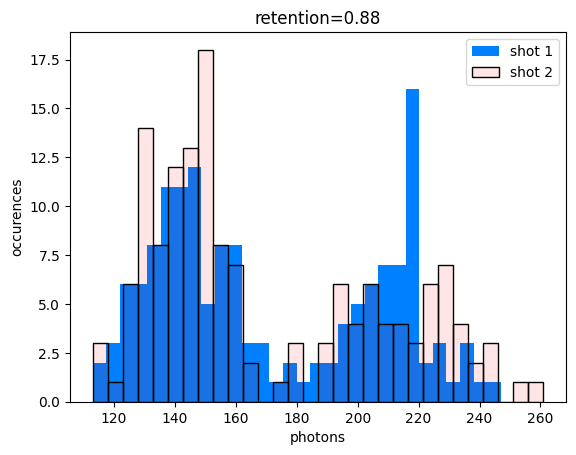

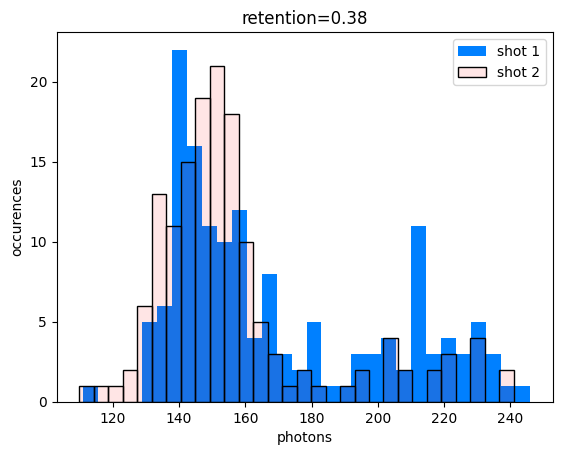

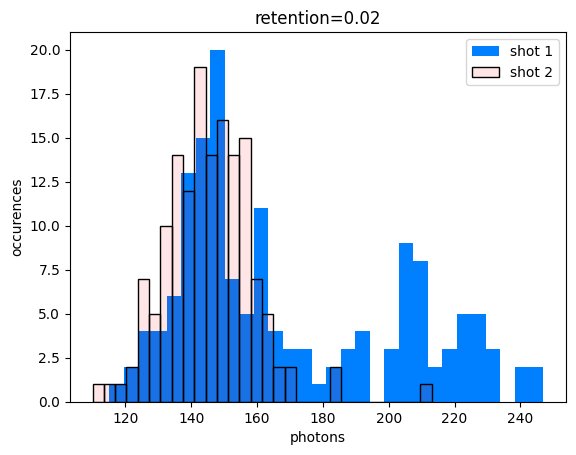

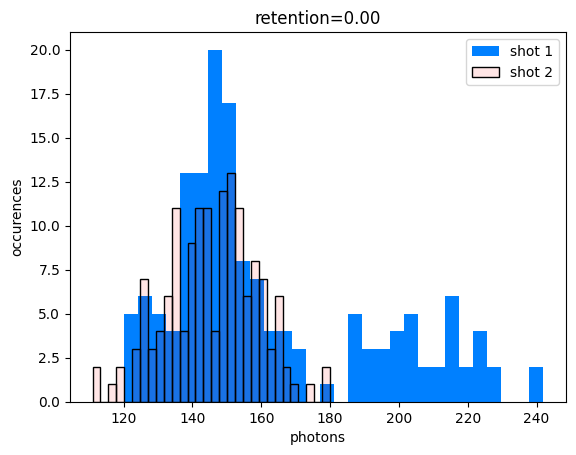

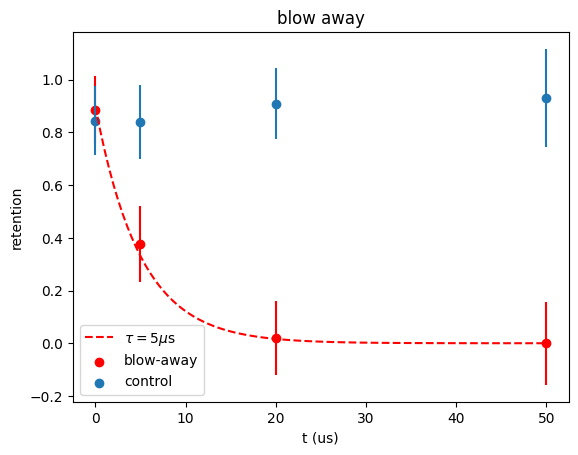

In [193]:
showhist = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [180]*len(t_arr)
retention_array = np.zeros(len(t_arr))
loading_rate_array = np.zeros(len(t_arr))

n_atoms_loaded_array = np.zeros(len(t_arr))

measurements = n_measurements if not control_experiment else n_measurements//2

for i,t in enumerate(t_arr):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    if showhist:
        plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        plt.title(f"retention={retention_fraction:.2f}")
        plt.ylabel("occurences")
        plt.xlabel("photons")
        plt.legend()
        plt.show()

tau = 5 # us
tpts = np.linspace(t_arr[0],t_arr[-1],100)/us
plt.plot(tpts, 0.9*np.exp(-tpts/tau),color='r',linestyle='--',label=r'$\tau=$'+f'{tau}'+r'$\mu$s')

errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
plt.scatter(t_arr/us, retention_array, label='blow-away',color='r')
t_pts = np.linspace(t_arr[0],t_arr[-1],100)
plt.title('blow away')
plt.errorbar(t_arr/us,retention_array, errs, ls='none',color='r')
plt.ylabel("retention")
plt.xlabel("t (us)")

if control_experiment:
    retention_array = np.zeros(len(t_arr))
    loading_rate_array = np.zeros(len(t_arr))
    
    n_atoms_loaded_array = np.zeros(len(t_arr))
    
    for i,t in enumerate(t_arr):
        shot1 = counts_shot1_control[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2_control[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff[i] for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
        # if showhist:
        #     plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     plt.title(f"control, retention={retention_fraction:.2f}")
        #     plt.ylabel("occurences")
        #     plt.xlabel("photons")
        #     plt.legend()
        #     plt.show()
    
    plt.scatter(t_arr/us, retention_array, label='control')
    t_pts = np.linspace(t_arr[0],t_arr[-1],100)
    # plt.title('blow away')
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
    plt.errorbar(t_arr/us,retention_array,errs,ls='none')
    plt.legend()
    # plt.ylabel("retention")
    # plt.xlabel("t (us)")

### 2023.12.04

In [171]:

# try lowering the trap depth
fname = "2023-12-04\\13\\000008162-SingleAtomBlowawayScan.h5"

# clear difference between blow-away and control, but the control doesn't lower the trap depth
fname = "2023-12-04\\13\\000008163-SingleAtomBlowawayScan.h5"

# set the cooling to be resonant with a free space atom during the blow-away
fname = "2023-12-04\\14\\000008173-SingleAtomBlowawayScan.h5" # showing first evidence of atom loss, but could be due to lower trap

# controlled experiment with the blow-away light off, so any loss is due to the FORT being low
fname = "2023-12-04\\15\\000008176-SingleAtomBlowawayScan.h5"

# more rigorous version of above experiment-- the double pass is off during the blow-away now.
fname = "2023-12-04\\15\\000008178-SingleAtomBlowawayScan.h5" # shows that the FORT lowering alone is responsible for atom loss

# raised the fractional FORT power to 0.4 compared to 0.2 in the previous experiment
fname = "2023-12-04\\16\\000008184-SingleAtomBlowawayScan.h5" # shows that the atom survival is now just as good with the FORT lowered

# exact same as previous experiment as a reproduceability check
fname = "2023-12-04\\16\\000008185-SingleAtomBlowawayScan.h5" # small sample size but the conclusion is that the FORT is high enough to not reduce retention.
# why would lowering the FORT without BA light reduce the retention anyway, unless it's because we're giving the atoms a kick?

# same as previous but now with BA light
fname = "2023-12-04\\16\\000008186-SingleAtomBlowawayScan.h5"

# same as previous but twice as many measurements per iteration

# controlled experiment but now the only difference in the control is that the blow-away light is off
fname = "2023-12-04\\17\\000008198-SingleAtomBlowawayScan.h5"

# controlled experiment but now the only difference in the control is that the blow-away light is off
fname = "2023-12-04\\17\\000008202-SingleAtomBlowawayScan.h5"

f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [172]:
n_measurements = np.uint(f['datasets']['n_measurements'])
control_experiment = np.bool_(f['datasets']['control_experiment'])

try:
    blowaway_light_off = np.bool_(f['datasets']['blowaway_light_off'])
except KeyError:
    pass
print("control experiment?", control_experiment)
if control_experiment:
    print("only excluded blowaway light?", np.bool_(f['datasets']['only_exclude_blowaway_light']))

if control_experiment:
    counts_shot1_all = list(f['datasets']['photocounts'])[1:]
    counts_shot1_control = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot1 = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==1]

    counts_shot2_all = list(f['datasets']['photocounts2'])[1:]
    counts_shot2_control = [counts_shot2_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot2 = [counts_shot2_all[i] for i in range(len(counts_shot1_all)) if i%2==1]
else:
    counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
    counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

t_arr = eval_str_from_h5(f['datasets']['t_blowaway'])
offset = eval_str_from_h5(f['datasets']['t_blowaway'])
print("MOT AOMs on the whole time?", control_experiment)
print("Blow-away light off?", blowaway_light_off)

print("PGC phase?", np.bool_(f['datasets']['do_PGC_in_MOT']))

control experiment? True
only excluded blowaway light? True
MOT AOMs on the whole time? True
Blow-away light off? False
PGC phase? False


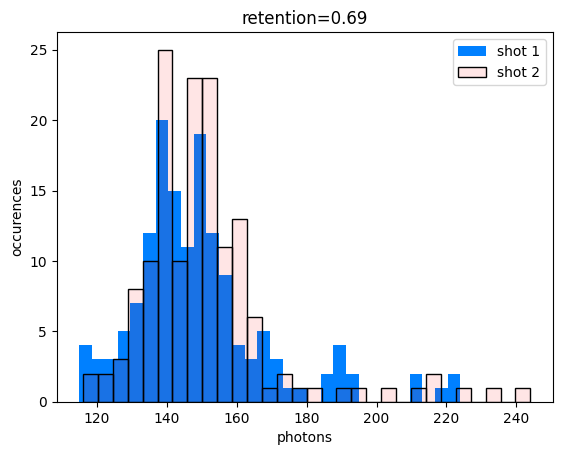

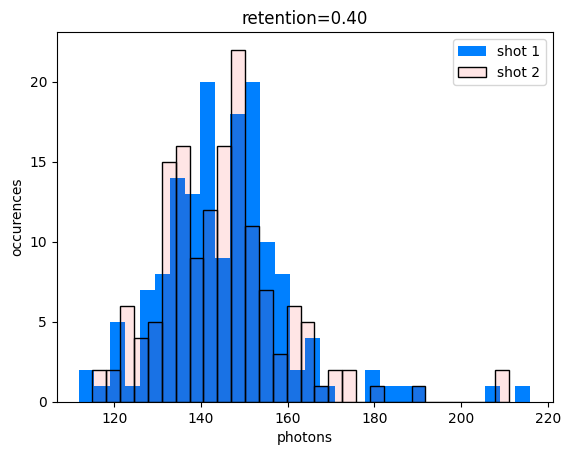

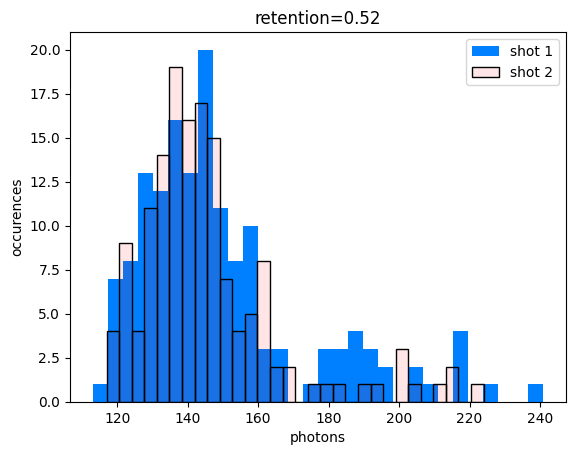

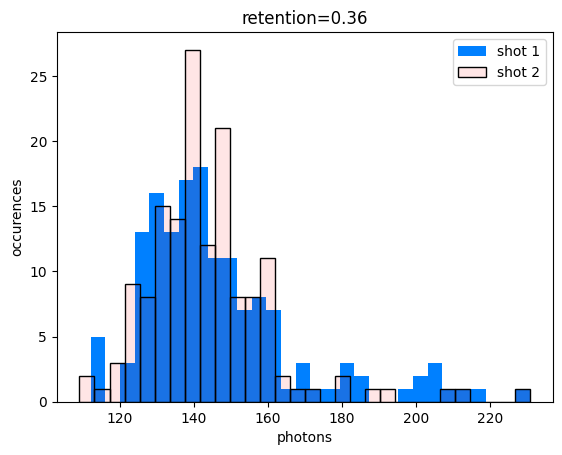

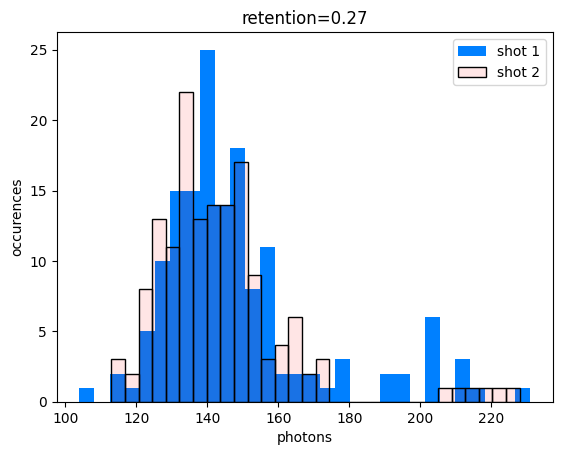

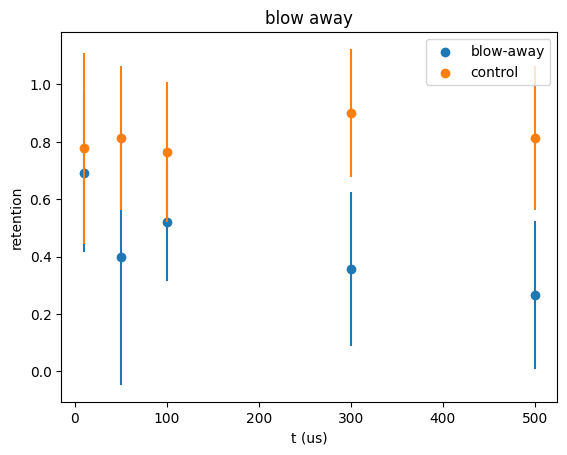

In [173]:
showhist = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [180]*len(t_arr)
retention_array = np.zeros(len(t_arr))
loading_rate_array = np.zeros(len(t_arr))

n_atoms_loaded_array = np.zeros(len(t_arr))

measurements = n_measurements if not control_experiment else n_measurements//2

for i,t in enumerate(t_arr):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    if showhist:
        plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        plt.title(f"retention={retention_fraction:.2f}")
        plt.ylabel("occurences")
        plt.xlabel("photons")
        plt.legend()
        plt.show()

errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
plt.scatter(t_arr/us, retention_array, label='blow-away')
t_pts = np.linspace(t_arr[0],t_arr[-1],100)
plt.title('blow away')
plt.errorbar(t_arr/us,retention_array, errs, ls='none')
plt.ylabel("retention")
plt.xlabel("t (us)")

if control_experiment:
    retention_array = np.zeros(len(t_arr))
    loading_rate_array = np.zeros(len(t_arr))
    
    n_atoms_loaded_array = np.zeros(len(t_arr))
    
    for i,t in enumerate(t_arr):
        shot1 = counts_shot1_control[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2_control[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff[i] for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
        # if showhist:
        #     plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     plt.title(f"control, retention={retention_fraction:.2f}")
        #     plt.ylabel("occurences")
        #     plt.xlabel("photons")
        #     plt.legend()
        #     plt.show()
    
    plt.scatter(t_arr/us, retention_array, label='control')
    t_pts = np.linspace(t_arr[0],t_arr[-1],100)
    # plt.title('blow away')
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
    plt.errorbar(t_arr/us,retention_array,errs,ls='none')
    plt.legend()
    # plt.ylabel("retention")
    # plt.xlabel("t (us)")

### 2023.12.01

In [102]:
# by mistake, these experiments were only doing the control experiment, i.e. no blowaway
# fname = "2023-12-01\\14\\000008096-SingleAtomBlowawayScan.h5"
# fname = "2023-12-01\\14\\000008097-SingleAtomBlowawayScan.h5" # the atom is not getting pushed out
# fname = "2023-12-01\\14\\000008101-SingleAtomBlowawayScan.h5" # the atom is not getting pushed out
# fname = "2023-12-01\\14\\000008106-SingleAtomBlowawayScan.h5" # the atom is not getting pushed out

# issue above has been fixed
# fname = "2023-12-01\\15\\000008111-SingleAtomBlowawayScan.h5" # the atom is not getting pushed out
# fname = "2023-12-01\\16\\000008113-SingleAtomBlowawayScan.h5" # the atom is not getting pushed out
# fname = "2023-12-01\\16\\000008115-SingleAtomBlowawayScan.h5" # the atom is not getting pushed out
fname = "2023-12-01\\16\\000008116-SingleAtomBlowawayScan.h5" # 1.5*cooling DP beam power
fname = "2023-12-01\\16\\000008117-SingleAtomBlowawayScan.h5" # 1.75*cooling DP beam power
fname = "2023-12-01\\16\\000008118-SingleAtomBlowawayScan.h5" # 1.5*cooling DP beam power and 1.5* MOT 1,4 beam power
fname = "2023-12-01\\17\\000008123-SingleAtomBlowawayScan.h5" # switching to MOT 6. waveform confirmed on scope, but probably not enough power

f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [103]:
n_measurements = np.uint(f['datasets']['n_measurements'])
control_experiment = np.bool_(f['datasets']['control_experiment'])
print("control experiment?", control_experiment)

if control_experiment:
    counts_shot1_all = list(f['datasets']['photocounts'])[1:]
    counts_shot1_control = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot1 = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==1]

    counts_shot2_all = list(f['datasets']['photocounts2'])[1:]
    counts_shot2_control = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot2 = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==1]
else:
    counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
    counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

t_arr = eval_str_from_h5(f['datasets']['t_blowaway'])
offset = eval_str_from_h5(f['datasets']['t_blowaway'])
print("MOT AOMs on the whole time?", control_experiment)
print("PGC phase?", np.bool_(f['datasets']['do_PGC_in_MOT']))

control experiment? False
MOT AOMs on the whole time? False
PGC phase? False


#### blowaway experiment

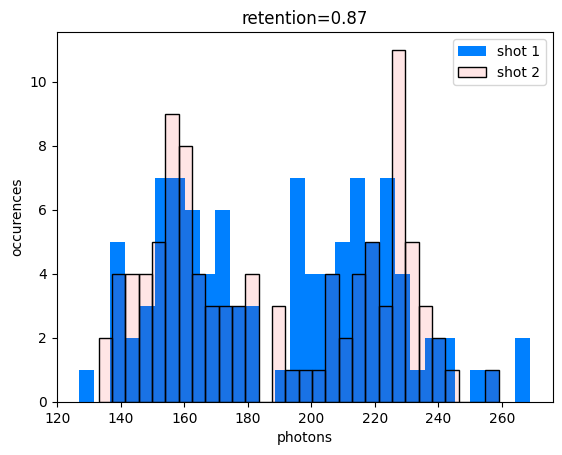

Text(0.5, 0, 't (us)')

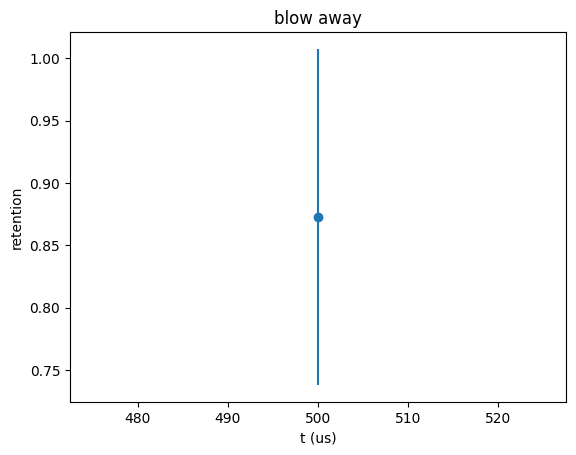

In [105]:
showhist = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [180]*len(t_arr)
retention_array = np.zeros(len(t_arr))
loading_rate_array = np.zeros(len(t_arr))

n_atoms_loaded_array = np.zeros(len(t_arr))

for i,t in enumerate(t_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    if showhist:
        plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        plt.title(f"retention={retention_fraction:.2f}")
        plt.ylabel("occurences")
        plt.xlabel("photons")
        plt.legend()
        plt.show()

plt.scatter(t_arr/us, retention_array)
t_pts = np.linspace(t_arr[0],t_arr[-1],100)
plt.title('blow away')
plt.errorbar(t_arr/us,retention_array,1/np.sqrt(n_atoms_loaded_array),ls='none')
plt.ylabel("retention")
plt.xlabel("t (us)")

#### control

In [72]:

showhist = False
# plot histogram for each iteration (iteration = experiment sequence with a particular blowaway time between shots)

cutoff = [180]*4
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))

n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_arr):
    shot1 = counts_shot1_control[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2_control[i*n_measurements:(i+1)*n_measurements]
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded
    
    if showhist:
        plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        plt.title(f"t_gap={t/us:.0f}us, retention={retention_fraction:.2f}")
        plt.ylabel("occurences")
        plt.xlabel("photons")
        plt.legend()
        plt.show()

plt.scatter(t_arr, retention_array)
t_pts = np.linspace(t_delay_arr[0],t_arr[-1],100)
plt.title('blow away')
plt.errorbar(t_arr,retention_array,1/np.sqrt(n_atoms_loaded_array),ls='none')
plt.ylabel("retention")
plt.xlabel("t (s)")

IndexError: index 2 is out of bounds for axis 0 with size 2

### 2023.11.30

In [11]:
# this is the first experiment to measure the time required for blowaway with a single cooling beam (AOM A1 in this case)

f = h5py.File(os.path.join(results, "2023-11-30\\16\\000008014-SingleAtomBlowawayScan.h5"))
[x for x in f['datasets']]

['AOM_A1_power',
 'AOM_A2_power',
 'AOM_A3_power',
 'AOM_A4_power',
 'AOM_A5_power',
 'AOM_A6_power',
 'FORT_monitor',
 'MOT1_monitor',
 'MOT2_monitor',
 'MOT3_monitor',
 'MOT4_monitor',
 'MOT5_monitor',
 'MOT6_monitor',
 'MOT_switchyard_monitor',
 'atom_counts_threshold',
 'atom_retention',
 'bins',
 'control_experiment',
 'do_PGC_in_MOT',
 'n_measurements',
 'no_first_shot',
 'p_cooling_DP_MOT',
 'photocount_bins',
 'photocounts',
 'photocounts2',
 'scan_datasets',
 't_blowaway']

In [19]:
n_measurements = np.uint(f['datasets']['n_measurements'])
control_experiment = np.bool_(f['datasets']['control_experiment'])

if control_experiment:
    counts_shot1_all = list(f['datasets']['photocounts'])[1:]
    counts_shot1_control = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot1 = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==1]

    counts_shot2_all = list(f['datasets']['photocounts2'])[1:]
    counts_shot2_control = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot2 = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==1]
else:
    counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
    counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# photocounts_all = list(f['datasets']['photocounts'])[1:]
# photocounts_control = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==0]
# photocounts = [photocounts_all[i]/t_exp for i in range(len(photocounts_all)) if i%2==1]

t_delay_arr = eval_str_from_h5(f['datasets']['t_blowaway'])
offset = eval_str_from_h5(f['datasets']['t_blowaway'])
print("MOT AOMs on the whole time?", control_experiment)
print("PGC phase?", np.bool_(f['datasets']['do_PGC_in_MOT']))

MOT AOMs on the whole time? True
PGC phase? False


#### control

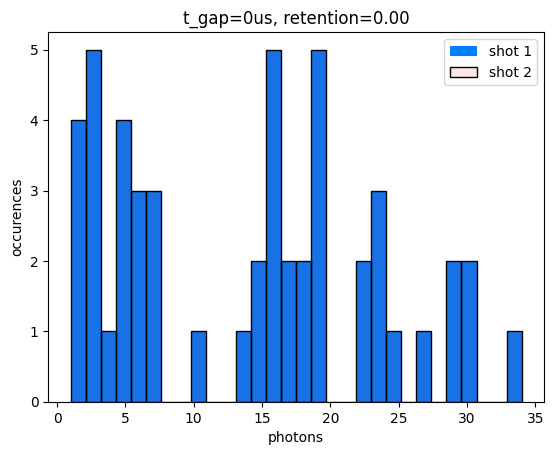

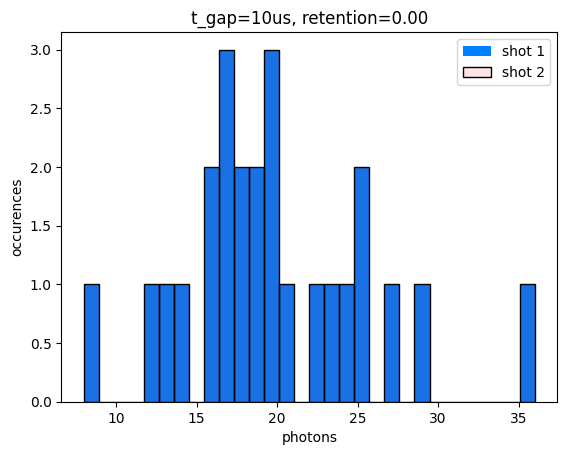

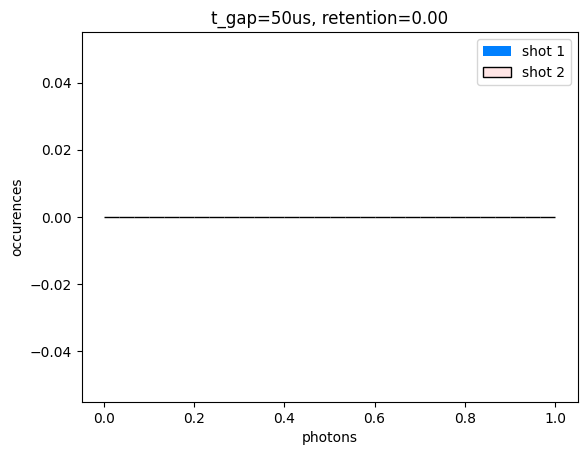

In [20]:
# plot histogram for each iteration (iteration = experiment sequence with a particular blowaway time between shots)
cutoff = [210]*4
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))

n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1_control[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2_control[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
    plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    plt.title(f"t_gap={t/us:.0f}us, retention={retention_fraction:.2f}")
    plt.ylabel("occurences")
    plt.xlabel("photons")
    plt.legend()
    plt.show()

#### blowaway experiment

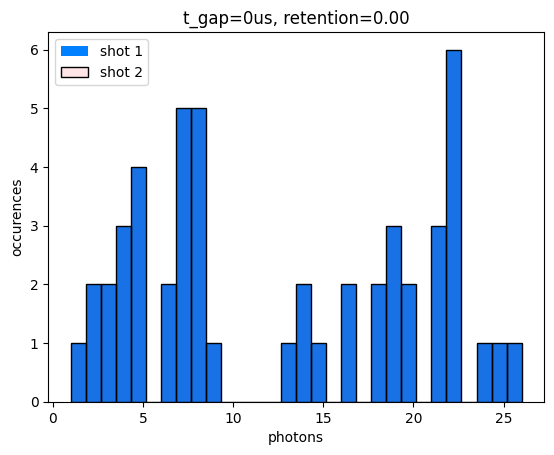

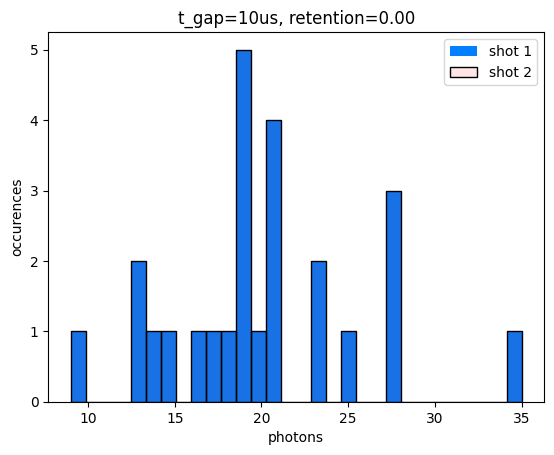

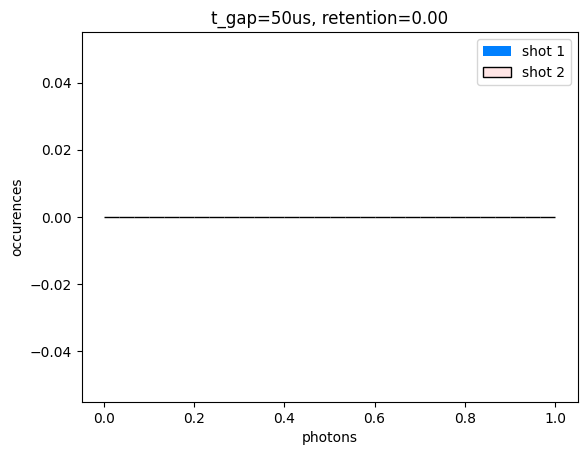

In [15]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [210]*4
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))

n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
    plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    plt.title(f"t_gap={t/us:.0f}us, retention={retention_fraction:.2f}")
    plt.ylabel("occurences")
    plt.xlabel("photons")
    plt.legend()
    plt.show()

Text(0.5, 0, 't (s)')

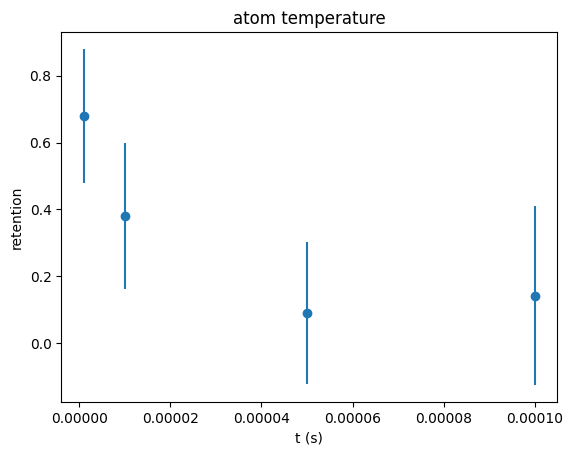

In [26]:
# plt.scatter(t_delay_arr/us, retention_array/retention_array[0])
# t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
# tau = 1.75
# plt.title('atom temperature')
# # plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
# plt.ylabel("retention (normalized)")
# plt.xlabel("t (us)")
# # plt.xlim((0,1.1))
# # plt.legend()

plt.scatter(t_delay_arr, retention_array)
t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
plt.title('atom temperature')
plt.errorbar(t_delay_arr,retention_array,1/np.sqrt(n_atoms_loaded_array),ls='none')
plt.ylabel("retention")
plt.xlabel("t (s)")
# plt.xlim((0,1.1))
# plt.legend()

In [23]:
n_atoms_loaded_array

array([25., 21., 22., 14.])

In [15]:
retention_array

array([0.68      , 0.38095238, 0.09090909, 0.14285714])

Text(0.5, 0, 'minutes')

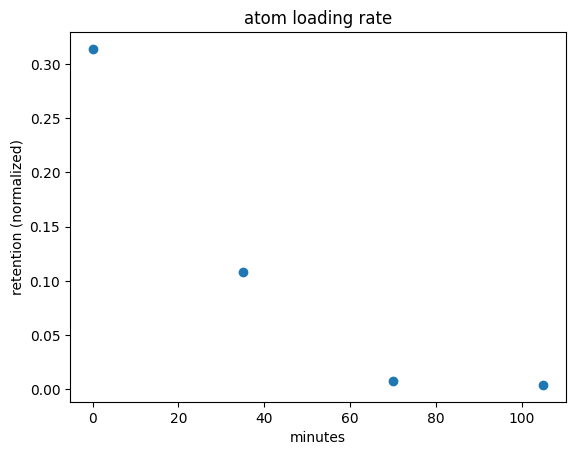

In [103]:
time = np.linspace(0,60+45,4)
plt.scatter(time,loading_rate_array)
plt.title('atom loading rate')
# plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
plt.ylabel("retention (normalized)")
plt.xlabel("minutes")

In [ ]:
19

In [ ]:
plt.plot()

In [ ]:
# t_FORT_loading = np.single(f['archive']['t_FORT_loading'])
# photocounts = np.array(f['datasets']['photocounts'])[1:]
# measurements = np.uint(f['datasets']['n_measurements'])
# t_FORT_loading_list.append(t_FORT_loading)
# photocounts_list.append(photocounts)

# threshold = 260
# atoms = len(photocounts[photocounts>threshold])
# r_loading = atoms/len(photocounts)
# plt.hist(photocounts, bins=bins)#,alpha=0.5)
# plt.title(f't_FORT_loading={t_FORT_loading/0.001:.0f}ms, r_loading={r_loading:.2f}')
# plt.xlabel("photons")
# plt.ylabel("occurrences")
# # plt.savefig(f'atom_loading_20231012_{bins}_bins.pdf')
# plt.show()

In [24]:
ids = ['2023-10-23\\09\\000006656','2023-10-23\\09\\000006661','2023-10-23\\10\\000006663']
t_FORT_loading_list = []
photocounts_list = []
for id in ids:
    f = h5py.File(os.path.join(results, f'{id}-SimpleAtomTrapNoChop.h5'))
    # [x for x in f['datasets'].values()]
    t_FORT_loading = np.single(f['archive']['t_FORT_loading'])
    photocounts = np.array(f['datasets']['photocounts'])[1:]
    measurements = np.uint(f['datasets']['n_measurements'])
    t_FORT_loading_list.append(t_FORT_loading)
    photocounts_list.append(photocounts)

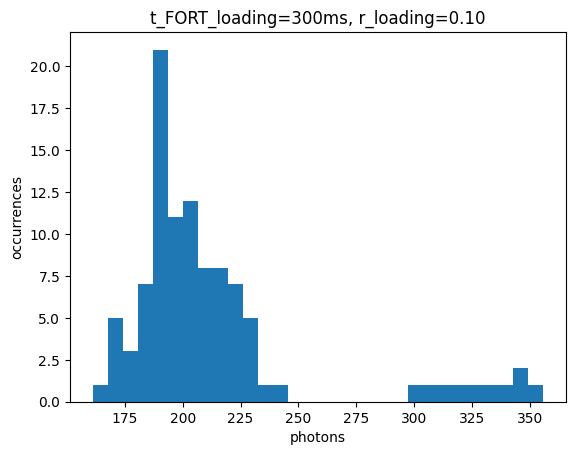

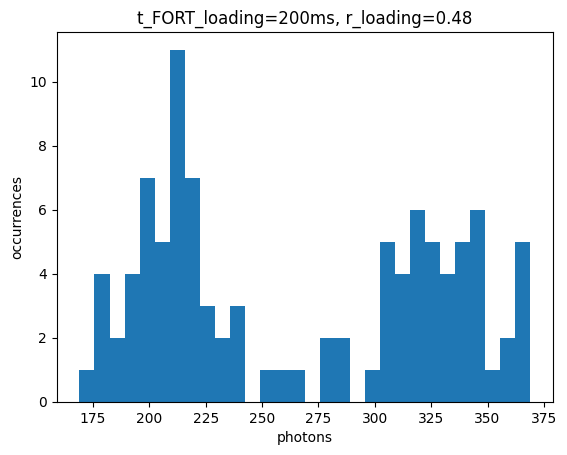

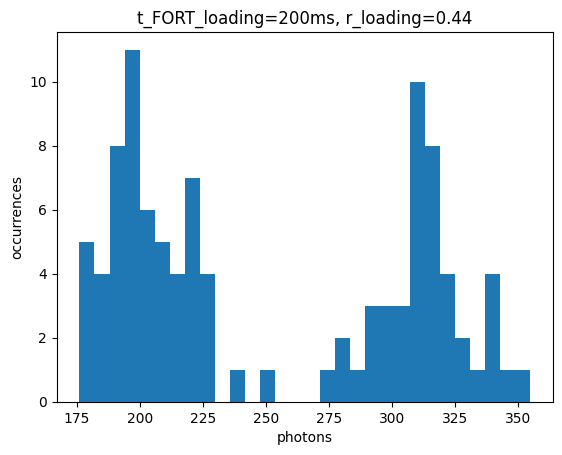

In [26]:
bins = 30
threshold = 270
for t_FORT_loading,photocounts in zip(t_FORT_loading_list,photocounts_list):
    atoms = len(photocounts[photocounts>threshold])
    r_loading = atoms/len(photocounts)
    plt.hist(photocounts, bins=bins)#,alpha=0.5)
    plt.title(f't_FORT_loading={t_FORT_loading/0.001:.0f}ms, r_loading={r_loading:.2f}')
    plt.xlabel("photons")
    plt.ylabel("occurrences")
    # plt.savefig(f'atom_loading_20231012_{bins}_bins.pdf')
    plt.show()